<a href="https://colab.research.google.com/github/ankit-rathi/Tradevesting_v1/blob/main/Rough_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from datetime import datetime
from scipy.optimize import newton

def calculate_xirr(dates, cash_flows):
    def xnpv(rate):
        return sum(cf / ((1 + rate) ** ((date - dates[0]).days / 365)) for date, cf in zip(dates, cash_flows))
    return newton(xnpv, 0.1)

# Load data
df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myInvestments.csv')
df['Date'] = pd.to_datetime(df['Date'], format="%d-%b-%y")

# Extract inputs
dates = list(df['Date'])
cash_flows = list(df['Investment'])

# Define corpus
today = pd.to_datetime('30-Jul-2025', format="%d-%b-%Y") #pd.to_datetime(datetime.today().date())
corpus_value = 15000000  # Replace with actual

# Append current corpus
dates_with_corpus = dates + [today]
cash_flows_with_corpus = cash_flows + [corpus_value]

# XIRR calculation
xirr_with_corpus = calculate_xirr(dates_with_corpus, cash_flows_with_corpus)

# Absolute return
total_investment = -sum([cf for cf in cash_flows])
absolute_return = corpus_value - total_investment
absolute_return_pct = (absolute_return / total_investment) * 100

# Results
print(f"📊 Total Investment ₹{total_investment}")
print(f"📊 XIRR with current corpus ₹{corpus_value} ({xirr_with_corpus * 100:.2f}%)")
print(f"📈 Absolute Return: ₹{absolute_return} ({absolute_return_pct:.2f}%)")

📊 Total Investment ₹11654190
📊 XIRR with current corpus ₹15000000 (16.72%)
📈 Absolute Return: ₹3345810 (28.71%)


In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=4bd0356d97d1507474936c81c67730dafd066f4a9cc727dfbefd7c4aefb324a9
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


[*********************100%***********************]  8 of 8 completed


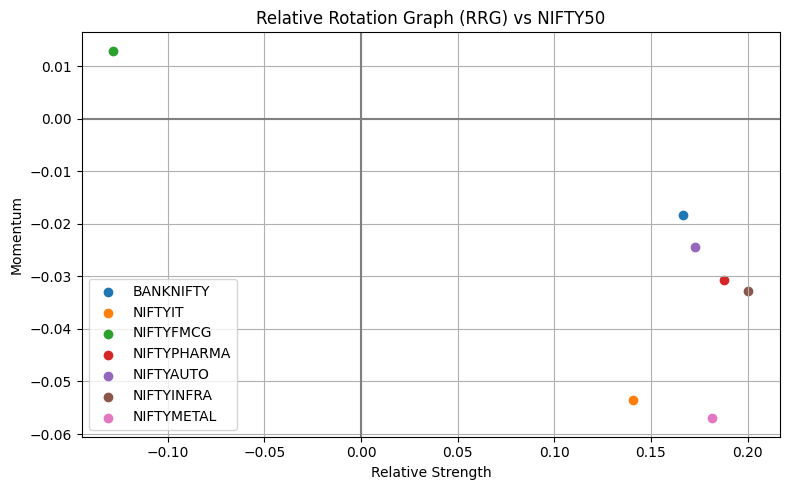

In [15]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Define tickers
tickers = {
    "NIFTY50": "^NSEI",
    "BANKNIFTY": "^NSEBANK",
    "NIFTYIT": "^CNXIT",
    "NIFTYFMCG": "^CNXFMCG",
    "NIFTYPHARMA": "^CNXPHARMA",
    "NIFTYAUTO": "^CNXAUTO",
    "NIFTYINFRA": "^CNXINFRA",
    "NIFTYMETAL": "^CNXMETAL"
}

# Download data
data = yf.download(list(tickers.values()), start="2024-01-01", end="2025-05-30")['Close']
data.columns = tickers.keys()

# Daily returns
returns = data.pct_change().dropna()

# Relative returns to NIFTY50
relative_returns = returns.div(returns["NIFTY50"], axis=0)

# Rolling mean and momentum
relative_strength = relative_returns.rolling(window=5).mean()
momentum = relative_strength.diff()

# Normalize
scaler = StandardScaler()
rs_scaled = scaler.fit_transform(relative_strength.drop(columns="NIFTY50").dropna())
mo_scaled = scaler.fit_transform(momentum.drop(columns="NIFTY50").dropna())

# Latest values
x = rs_scaled[-1]
y = mo_scaled[-1]
labels = relative_strength.columns.drop("NIFTY50")

# Plot RRG
plt.figure(figsize=(8, 5))
plt.axhline(0, color='grey')
plt.axvline(0, color='grey')

for i, label in enumerate(labels):
    plt.scatter(x[i], y[i], label=label)
    #plt.text(x[i] + 0.02, y[i] + 0.02, label, fontsize=12)

plt.title("Relative Rotation Graph (RRG) vs NIFTY50")
plt.xlabel("Relative Strength")
plt.ylabel("Momentum")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
